# TSNN examples

## Summary

- In narrow format, both lin reg and fully connected manage to capture a linear effect between features and target. A linear regression will always be better in this case since this is constrained to be exactly the function of the ground truth


In [33]:
%load_ext autoreload
%autoreload 2

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from sklearn.linear_model import LassoCV, RidgeCV, LinearRegression
import torch
from torch.utils.data import Dataset, random_split
from torch.utils.data import DataLoader
import importlib
import sys
sys.path.append('/Users/cyrilgarcia/notebooks/tsnn/')

import tsnn

from tsnn.generators import generators
from tsnn.benchmarks import benchmark_comparison, ml_benchmarks, torch_benchmarks
from tsnn import utils
import torch.nn.functional as F
import math
from typing import Optional


plt.style.use('ggplot')

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
from dataclasses import dataclass

@dataclass
class Config:
    T: int = 3000
    n_ts: int = 50
    n_f: int = 10
    pct_zero_corr: float = 0.5
    split_conditional: float = 0.
    split_shift: float = 1.0
    split_seasonal: float = 0.
    low_corr: float = 0.1
    high_corr: float = 0.2

In [3]:
z = generators.Generator(Config.T, Config.n_ts, Config.n_f)

In [4]:
%%time
z.generate_dataset(pct_zero_corr = Config.pct_zero_corr,
                  split_conditional = Config.split_conditional,
                  split_shift = Config.split_shift,
                  split_seasonal = Config.split_seasonal,
                  low_corr=Config.low_corr, 
                   high_corr=Config.high_corr)

CPU times: user 438 ms, sys: 42.2 ms, total: 480 ms
Wall time: 88.4 ms


In [5]:
z.get_dataloader()

### Simple benchmarks

In [6]:
# lasso benchmark
lasso = ml_benchmarks.LassoBenchmark()
lasso.fit(z.train)

In [7]:
lasso.score(z.train)

np.float64(0.004876919384277655)

In [8]:
# any custom benchmark
from sklearn.linear_model import LinearRegression
lr = ml_benchmarks.CustomBenchmark(LinearRegression())
lr.fit(z.train)

In [9]:
comp = benchmark_comparison.Comparator(models=[lasso, lr], model_names=['lasso', 'lr'])

In [10]:
comp.correl(z, mode='train')

,true,optimal,shift,lasso
optimal,0.3481,nan,nan,nan
shift,0.3481,1.0000,nan,nan
lasso,0.0036,0.0024,0.0024,nan
lr,0.0073,0.0018,0.0018,0.6268


In [11]:
comp.correl(z, mode='test')

,true,optimal,shift,lasso
optimal,0.3388,nan,nan,nan
shift,0.3388,1.0000,nan,nan
lasso,-0.0010,0.0023,0.0023,nan
lr,-0.0017,0.0023,0.0023,0.6614


## Torch benchmarks - narrow matrix (no cross-TS interactions)

### Fully connected

Equivalent to linear regression setup

In [132]:
z.get_dataloader(narrow=True)

In [133]:
from torch import nn
device = 'mps'

class NeuralNetwork(nn.Module):
    def __init__(self, n_f):
        super().__init__()
        self.flatten = nn.Flatten()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(n_f, 256),
            nn.ReLU(),
            nn.Linear(256, 1),
        )
        
    def forward(self, x):
        pred = self.linear_relu_stack(x)
        return pred

In [134]:
m = NeuralNetwork(n_f=Config.n_f).to(device)
optimizer = torch.optim.Adam(m.parameters(), lr=1e-3)


full_nn = torch_benchmarks.TorchWrapper(m, optimizer=optimizer)

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:11<00:00,  1.16s/it]


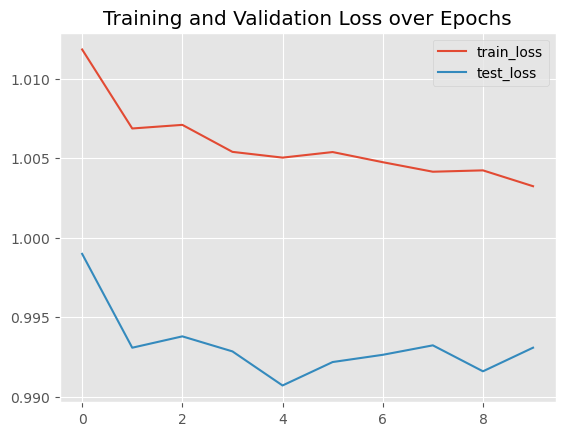

In [135]:
full_nn.fit(z.train, z.test, epochs=10)

In [136]:
comp = benchmark_comparison.Comparator(models=[full_nn, lasso], model_names=['nn', 'lasso'])

In [137]:
comp.correl(z, mode='train')

,true,optimal,shift
optimal,0.3448,nan,nan
shift,0.3448,1.0000,nan
nn,0.0550,0.0230,0.0230


In [138]:
comp.correl(z, mode='test')

,true,optimal,shift
optimal,0.3400,nan,nan
shift,0.3400,1.0000,nan
nn,-0.0049,0.0033,0.0033


### LSTM

Equivalent to linear regression setup

In [139]:
z.get_dataloader(n_rolling=5, narrow=True, train_test_split=True, shuffle=False)

In [140]:
from torch import nn
device = 'mps'

class LSTMModel(nn.Module):
    def __init__(self, n_f, hidden_dim=32):
        super().__init__()
        self.encoder = nn.LSTM(input_size=n_f, hidden_size=hidden_dim, batch_first=True, num_layers=2)
        self.decoder = nn.Linear(hidden_dim, 1)
    
    def forward(self, x):
        # x: (batch, T=10, n_f)
        _, (h, _) = self.encoder(x)
        out = self.decoder(h[-1]) 
        return out

In [142]:
m = LSTMModel(n_f=Config.n_f).to(device)
optimizer = torch.optim.Adam(m.parameters(), lr=0.001)


model_lstm = torch_benchmarks.TorchWrapper(m, optimizer=optimizer)

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:28<00:00,  2.88s/it]


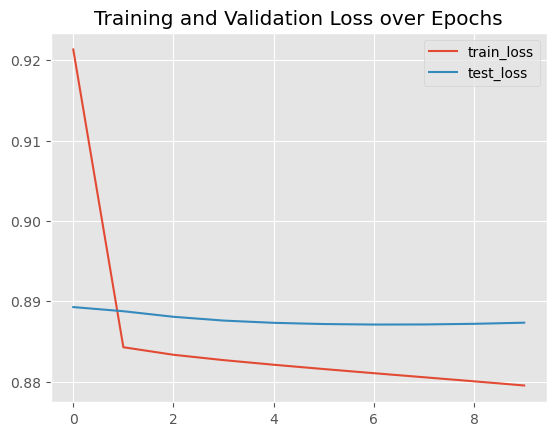

In [143]:
model_lstm.fit(z.train, test=z.test, epochs=10)

In [144]:
comp = benchmark_comparison.Comparator(models=[model_lstm, lasso], model_names=['lstm', 'lasso'])

In [145]:
comp.correl(z, mode='train')

,true,optimal,shift
optimal,0.3435,nan,nan
shift,0.3435,1.0000,nan
lstm,0.3493,0.9868,0.9868


In [146]:
comp.correl(z, mode='test')

,true,optimal,shift
optimal,0.3431,nan,nan
shift,0.3431,1.0000,nan
lstm,0.3390,0.9868,0.9868


### Transformer

In [147]:
class TransformerEncoderModel(nn.Module):
    def __init__(self, n_f, n_rolling, d_model=64, nhead=4, num_layers=1, dropout=0.5):
        super().__init__()
        self.input_dim = n_f
        self.d_model = d_model

        # Linear projection of n_f features
        self.input_proj = nn.Linear(self.input_dim, d_model)

        # Positional encoding (learned or sinusoidal)
        self.pos_embedding = nn.Parameter(torch.randn(1, n_rolling, d_model))

        # Transformer encoder
        encoder_layer = nn.TransformerEncoderLayer(
            d_model=d_model,
            nhead=nhead,
            dim_feedforward=4 * d_model,
            dropout=dropout,
            batch_first=True
        )
        self.encoder = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)

        # prediction
        self.decoder = nn.Sequential(
            # nn.LayerNorm(d_model),
            nn.Linear(d_model, 1)
        )

    def forward(self, x, mask=None):
        # x: (batch, n_rolling, n_f)
        # print(x.shape)
        B, n_rolling, n_f = x.shape

        x = self.input_proj(x) + self.pos_embedding[:, :n_rolling, :]

        # pass through Transformer encoder
        causal_mask = torch.triu(torch.ones(n_rolling, n_rolling, device=x.device), diagonal=1).bool()
        encoded = self.encoder(x, src_key_padding_mask=mask, mask=causal_mask)

        # last time step’s embedding for prediction
        out = self.decoder(encoded[:, -1, :])  # (B, N)
        
        # encoded = self.encoder(x, mask=causal_mask)#[: x.size(1), : x.size(1)])
        # out = self.decoder(encoded[:, -1, :]).squeeze(-1)
        # print(out.shape)
        # 1/0
        return out.reshape((-1, 1))

In [148]:
m = TransformerEncoderModel(Config.n_f, 5).to(device)

optimizer = torch.optim.Adam(m.parameters(), lr=0.001)


model_torch = torch_benchmarks.TorchWrapper(m, optimizer=optimizer)

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [01:29<00:00,  4.46s/it]


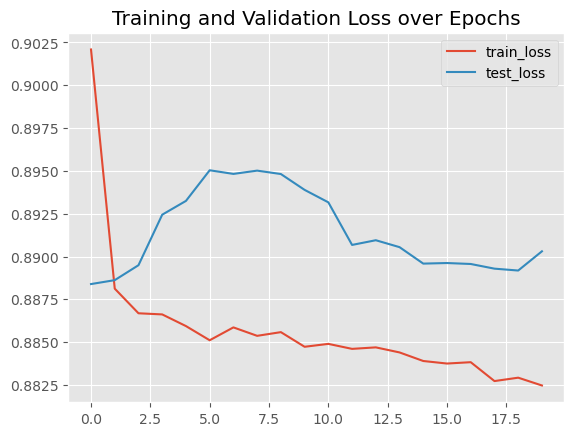

In [149]:
model_torch.fit(z.train, test=z.test, epochs=20)

In [150]:
comp = benchmark_comparison.Comparator(models=[model_torch, lasso], model_names=['transformer', 'lasso'])

In [151]:
comp.correl(z, mode='train')

,true,optimal,shift
optimal,0.3435,nan,nan
shift,0.3435,1.0000,nan
transformer,0.3467,0.9913,0.9913


In [152]:
comp.correl(z, mode='test')

,true,optimal,shift
optimal,0.3431,nan,nan
shift,0.3431,1.0000,nan
transformer,0.3398,0.9918,0.9918


## Torch benchmarks - wide matrix (cross-TS interactions)

### Fully connected

In [12]:
z.get_dataloader()

In [13]:
from torch import nn
device = 'mps'

class NeuralNetwork(nn.Module):
    def __init__(self, n_ts, n_f):
        super().__init__()
        self.flatten = nn.Flatten()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(n_ts*n_f, 512),
            nn.ReLU(),
            # nn.Linear(512, 512),
            # nn.ReLU(),
            nn.Linear(512, n_ts),
        )
        
        self.linear_relu_stack = nn.Sequential(nn.Linear(n_ts*n_f, 512),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(512, 512),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(512, n_ts)
                                              )

    def forward(self, x):
        x = self.flatten(x)
        pred = self.linear_relu_stack(x)
        return pred

In [14]:
m = NeuralNetwork(n_ts=Config.n_ts, n_f=Config.n_f).to(device)
optimizer = torch.optim.Adam(m.parameters(), lr=1e-3, weight_decay=1e-2)


full_nn = torch_benchmarks.TorchWrapper(m, optimizer=optimizer)

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:01<00:00, 16.79it/s]


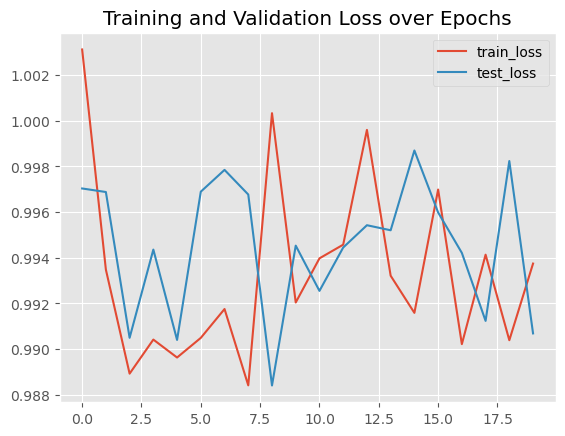

In [15]:
full_nn.fit(z.train, z.test, epochs=20)

In [16]:
comp = benchmark_comparison.Comparator(models=[lasso, lr, full_nn], model_names=['lasso', 'lr', 'nn'])

In [17]:
comp.correl(z, mode='train')

,true,optimal,shift,lasso,lr
optimal,0.3481,nan,nan,nan,nan
shift,0.3481,1.0000,nan,nan,nan
lasso,0.0036,0.0024,0.0024,nan,nan
lr,0.0073,0.0018,0.0018,0.6268,nan
nn,0.0166,0.0034,0.0034,-0.0008,0.0010


In [18]:
comp.correl(z, mode='test')

,true,optimal,shift,lasso,lr
optimal,0.3388,nan,nan,nan,nan
shift,0.3388,1.0000,nan,nan,nan
lasso,-0.0010,0.0023,0.0023,nan,nan
lr,-0.0017,0.0023,0.0023,0.6614,nan
nn,-0.0046,0.0021,0.0021,-0.0035,0.0001


### LSTM model with 10 timestamps

In [19]:
z.get_dataloader(n_rolling=10)

In [20]:
from torch import nn
device = 'mps'

class LSTMModel(nn.Module):
    def __init__(self, n_ts, n_f, n_rolling, hidden_dim=128):
        super().__init__()
        self.encoder = nn.LSTM(input_size=n_ts*n_f, hidden_size=hidden_dim, batch_first=True)
        self.decoder = nn.Linear(hidden_dim, n_ts)
    
    def forward(self, x):
        # warning: lstm dimension needs to be flattened:
        # x: (batch, T=10, n_ts*n_f)
        _, (h, _) = self.encoder(x.reshape(x.shape[0], x.shape[1], x.shape[2] * x.shape[3]))
        out = self.decoder(h[-1]) 
        return out

In [21]:
m = LSTMModel(n_ts=Config.n_ts, n_f=Config.n_f, n_rolling=10).to(device)
optimizer = torch.optim.Adam(m.parameters(), lr=0.001)


model_lstm = torch_benchmarks.TorchWrapper(m, optimizer=optimizer)

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 200/200 [00:23<00:00,  8.63it/s]


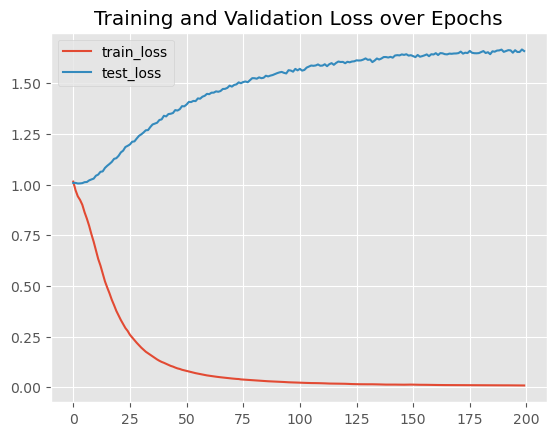

In [22]:
model_lstm.fit(z.train, test=z.test, epochs=200)

In [23]:
comp = benchmark_comparison.Comparator(models=[lasso, lr, model_lstm], model_names=['lasso', 'lr', 'lstm'])

In [24]:
comp.correl(z, mode='train')

,true,optimal,shift,lasso,lr
optimal,0.3481,nan,nan,nan,nan
shift,0.3481,1.0000,nan,nan,nan
lasso,0.0036,0.0024,0.0024,nan,nan
lr,0.0073,0.0018,0.0018,0.6268,nan
lstm,0.9963,0.3474,0.3474,0.0031,0.0075


In [25]:
comp.correl(z, mode='test')

,true,optimal,shift,lasso,lr
optimal,0.3388,nan,nan,nan,nan
shift,0.3388,1.0000,nan,nan,nan
lasso,-0.0010,0.0023,0.0023,nan,nan
lr,-0.0017,0.0023,0.0023,0.6614,nan
lstm,0.0318,0.0358,0.0358,-0.0093,0.0073


### Transformer

In [26]:
class TransformerEncoderModel(nn.Module):
    def __init__(self, n_ts, n_f, n_rolling, d_model=128, nhead=8, num_layers=2, dropout=0.8):
        super().__init__()
        self.input_dim = n_ts * n_f
        self.d_model = d_model

        # Linear projection of (n_ts*n_f) features
        self.input_proj = nn.Linear(self.input_dim, d_model)

        # Positional encoding (learned or sinusoidal)
        self.pos_embedding = nn.Parameter(torch.randn(1, n_rolling, d_model))

        # Transformer encoder
        encoder_layer = nn.TransformerEncoderLayer(
            d_model=d_model,
            nhead=nhead,
            dim_feedforward=4 * d_model,
            dropout=dropout,
            batch_first=True
        )
        self.encoder = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)

        # prediction
        self.decoder = nn.Sequential(
            nn.LayerNorm(d_model),
            nn.Linear(d_model, n_ts)
        )

    def forward(self, x, mask=None):
        # x: (batch, n_rolling, n_ts, n_f)
        B, n_rolling, n_ts, n_f = x.shape

        # Flatten dimensions that are not lookback
        x = x.reshape(B, n_rolling, n_ts*n_f)
        x = self.input_proj(x) + self.pos_embedding[:, :n_rolling, :]

        # pass through Transformer encoder
        causal_mask = torch.triu(torch.ones(n_rolling, n_rolling, device=x.device), diagonal=1).bool()
        encoded = self.encoder(x, mask=causal_mask)  

        # last time step’s embedding for prediction
        out = self.decoder(encoded[:, -1, :])  # (B, N)
        return out

In [27]:
m = TransformerEncoderModel(Config.n_ts, Config.n_f, 10).to(device)
optimizer = torch.optim.Adam(m.parameters(), lr=0.001)


model_torch = torch_benchmarks.TorchWrapper(m, optimizer=optimizer)

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 200/200 [00:38<00:00,  5.23it/s]


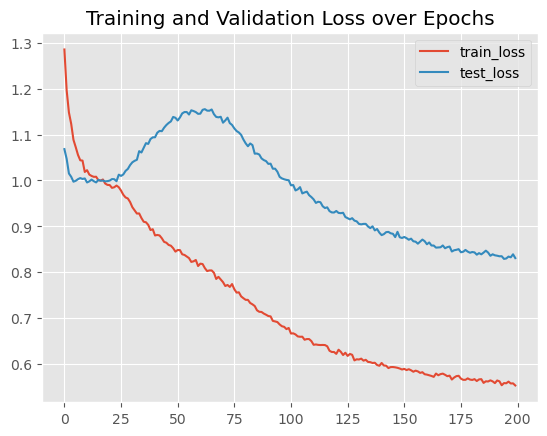

In [28]:
model_torch.fit(z.train, test=z.test, epochs=200)

In [29]:
comp = benchmark_comparison.Comparator(models=[lasso, lr, model_lstm, model_torch], model_names=['lasso', 'lr', 'lstm', 'transformer'])

In [30]:
comp.correl(z, mode='train')

,true,optimal,shift,lasso,lr,lstm
optimal,0.3481,nan,nan,nan,nan,nan
shift,0.3481,1.0000,nan,nan,nan,nan
lasso,0.0036,0.0024,0.0024,nan,nan,nan
lr,0.0073,0.0018,0.0018,0.6268,nan,nan
lstm,0.9963,0.3474,0.3474,0.0031,0.0075,nan
transformer,0.7709,0.3222,0.3222,0.0079,0.0115,0.7736


In [31]:
comp.correl(z, mode='test')

,true,optimal,shift,lasso,lr,lstm
optimal,0.3388,nan,nan,nan,nan,nan
shift,0.3388,1.0000,nan,nan,nan,nan
lasso,-0.0010,0.0023,0.0023,nan,nan,nan
lr,-0.0017,0.0023,0.0023,0.6614,nan,nan
lstm,0.0318,0.0358,0.0358,-0.0093,0.0073,nan
transformer,0.4734,0.2569,0.2569,0.0122,0.0154,0.2060


### Re-writing the transformer and checking that we get the same results

In [41]:
from torch.nn import ModuleList
import copy

def _get_clones(module, N):
    return nn.ModuleList([copy.deepcopy(module) for i in range(N)])

class MultiHeadAttention(nn.Module):
    """
    Computes multi-head attention. Supports nested or padded tensors.

    Args:
        E_q (int): Size of embedding dim for query
        E_k (int): Size of embedding dim for key
        E_v (int): Size of embedding dim for value
        E_total (int): Total embedding dim of combined heads post input projection. Each head
            has dim E_total // nheads
        nheads (int): Number of heads
        dropout (float, optional): Dropout probability. Default: 0.0
        bias (bool, optional): Whether to add bias to input projection. Default: True
    """
    def __init__(
        self,
        E_q: int,
        E_k: int,
        E_v: int,
        E_total: int,
        nheads: int,
        dropout: float = 0.0,
        bias=True,
        device=None,
        dtype=None,
    ):
        factory_kwargs = {"device": device, "dtype": dtype}
        super().__init__()
        self.nheads = nheads
        self.dropout = dropout
        self._qkv_same_embed_dim = E_q == E_k and E_q == E_v
        if self._qkv_same_embed_dim:
          self.packed_proj = nn.Linear(E_q, E_total * 3, bias=bias, **factory_kwargs)
        else:
          self.q_proj = nn.Linear(E_q, E_total, bias=bias, **factory_kwargs)
          self.k_proj = nn.Linear(E_k, E_total, bias=bias, **factory_kwargs)
          self.v_proj = nn.Linear(E_v, E_total, bias=bias, **factory_kwargs)
        E_out = E_q
        self.out_proj = nn.Linear(E_total, E_out, bias=bias, **factory_kwargs)
        assert E_total % nheads == 0, "Embedding dim is not divisible by nheads"
        self.E_head = E_total // nheads
        self.bias = bias

    def forward(self, query: torch.Tensor, key: torch.Tensor, value: torch.Tensor, attn_mask=None, is_causal=False) -> torch.Tensor:
        """
        Forward pass; runs the following process:
            1. Apply input projection
            2. Split heads and prepare for SDPA
            3. Run SDPA
            4. Apply output projection

        Args:
            query (torch.Tensor): query of shape (N, L_q, E_qk)
            key (torch.Tensor): key of shape (N, L_kv, E_qk)
            value (torch.Tensor): value of shape (N, L_kv, E_v)
            attn_mask (torch.Tensor, optional): attention mask of shape (N, L_q, L_kv) to pass to sdpa. Default: None
            is_causal (bool, optional): Whether to apply causal mask. Default: False

        Returns:
            attn_output (torch.Tensor): output of shape (N, L_t, E_q)
        """
        # Step 1. Apply input projection
        if self._qkv_same_embed_dim:
            if query is key and key is value:
                result = self.packed_proj(query)
                query, key, value = torch.chunk(result, 3, dim=-1)
            else:
                q_weight, k_weight, v_weight = torch.chunk(self.packed_proj.weight, 3, dim=0)
                if self.bias:
                    q_bias, k_bias, v_bias = torch.chunk(self.packed_proj.bias, 3, dim=0)
                else:
                    q_bias, k_bias, v_bias = None, None, None
                query, key, value = F.linear(query, q_weight, q_bias), F.linear(key, k_weight, k_bias), F.linear(value, v_weight, v_bias)

        else:
            query = self.q_proj(query)
            key = self.k_proj(key)
            value = self.v_proj(value)

        # Step 2. Split heads and prepare for SDPA
        # reshape query, key, value to separate by head
        # (N, L_t, E_total) -> (N, L_t, nheads, E_head) -> (N, nheads, L_t, E_head)
        query = query.unflatten(-1, [self.nheads, self.E_head]).transpose(1, 2)
        # (N, L_s, E_total) -> (N, L_s, nheads, E_head) -> (N, nheads, L_s, E_head)
        key = key.unflatten(-1, [self.nheads, self.E_head]).transpose(1, 2)
        # (N, L_s, E_total) -> (N, L_s, nheads, E_head) -> (N, nheads, L_s, E_head)
        value = value.unflatten(-1, [self.nheads, self.E_head]).transpose(1, 2)

        # Step 3. Run SDPA
        # (N, nheads, L_t, E_head)
        attn_output = F.scaled_dot_product_attention(
            query, key, value, dropout_p=self.dropout, is_causal=is_causal)
        # (N, nheads, L_t, E_head) -> (N, L_t, nheads, E_head) -> (N, L_t, E_total)
        attn_output = attn_output.transpose(1, 2).flatten(-2)

        # Step 4. Apply output projection
        # (N, L_t, E_total) -> (N, L_t, E_out)
        attn_output = self.out_proj(attn_output)

        return attn_output


class TransformerEncoder(nn.Module):
    def __init__(
        self,
        encoder_layer: "TransformerEncoderLayer",
        num_layers: int,
        norm: Optional[nn.Module] = None,
        device=None,
        dtype=None,
    ):
        factory_kwargs = {"device": device, "dtype": dtype}
        super().__init__()
        self.layers = _get_clones(encoder_layer, num_layers)
        self.num_layers = num_layers
        self.norm = norm

    def forward(self, src: torch.Tensor, mask: Optional[torch.Tensor] = None, is_causal=False):
        output = src
        for mod in self.layers:
            output = mod(output, mask, is_causal)
        if self.norm is not None:
            output = self.norm(output)
        return output


class TransformerDecoder(nn.Module):
    def __init__(
        self,
        decoder_layer: "TransformerDecoderLayer",
        num_layers: int,
        norm: Optional[nn.Module] = None,
    ):
        super().__init__()
        self.layers = _get_clones(decoder_layer, num_layers)
        self.num_layers = num_layers
        self.norm = norm
    
    def forward(
        self,
        tgt: torch.Tensor,
        memory: torch.Tensor,
        tgt_mask: Optional[torch.Tensor] = None,
        memory_mask: Optional[torch.Tensor] = None,
        tgt_is_causal=False,
        memory_is_causal=False
    ):
        output = tgt
        for mod in self.layers:
            output = mod(
                output,
                memory,
                tgt_mask=tgt_mask,
                memory_mask=memory_mask,
                tgt_is_causal=tgt_is_causal,
                memory_is_causal=memory_is_causal,
            )
        
        if self.norm is not None:
            output = self.norm(output)
        
        return output

class Transformer(nn.Module):
    def __init__(
        self,
        d_model,
        nhead,
        num_encoder_layers=6,
        num_decoder_layers=6,
        dim_feedforward=2048,
        dropout=0.1,
        activation : nn.Module = torch.nn.functional.relu,
        layer_norm_eps=1e-5,
        norm_first=True,
        bias=True,
        device='cpu',
    ):
        encoder_layer = TransformerEncoderLayer(
            d_model,
            nhead,
            dim_feedforward,
            dropout,
            activation,
            layer_norm_eps,
            batch_first=True,
            norm_first=norm_first,
            bias=bias,
            device=device,
        )
        encoder_norm = nn.LayerNorm(d_model, eps=layer_norm_eps, bias=bias, device=device)
        self.encoder = TransformerEncoder(
            encoder_layer, num_encoder_layers, encoder_norm
        )

        decoder_layer = TransformerDecoderLayer(
            d_model,
            nhead,
            dim_feedforward,
            dropout,
            activation,
            layer_norm_eps,
            bias=bias,
            device=device,
        )
        decoder_norm = nn.LayerNorm(
            d_model, eps=layer_norm_eps, bias=bias, device=device
        )
        self.decoder = TransformerDecoder(
            decoder_layer, num_decoder_layers, decoder_norm
        )

    def forward(
        self,
        src,
        tgt,
        src_mask=None,
        tgt_mask=None, 
        memory_mask=None,
        src_is_causal=False,
        tgt_is_causal=False,
        memory_is_causal=False,
    ):
        memory = self.encoder(
            src,
            mask=src_mask,
            is_causal=src_is_causal,
        )
        output = self.decoder(
            tgt,
            memory,
            tgt_mask=tgt_mask,
            memory_mask=memory_mask,
            tgt_is_causal=tgt_is_causal,
            memory_is_causal=memory_is_causal,
        )
        return output


class TransformerEncoderLayer(nn.Module):
    def __init__(
        self,
        d_model,
        nhead,
        dim_feedforward=2048,
        dropout=0.1,
        activation : nn.Module = torch.nn.functional.relu,
        layer_norm_eps=1e-5,
        norm_first=True,
        bias=True,
        device=None,
        dtype=None,
    ):
        factory_kwargs = {"device": device, "dtype": dtype}
        super().__init__()
        self.self_attn = MultiHeadAttention(
            d_model,
            d_model,
            d_model,
            d_model,
            nhead,
            dropout=dropout,
            bias=bias,
            **factory_kwargs,
        )
        self.linear1 = nn.Linear(d_model, dim_feedforward, bias=bias, **factory_kwargs)
        self.dropout = nn.Dropout(dropout)
        self.linear2 = nn.Linear(dim_feedforward, d_model, bias=bias, **factory_kwargs)

        self.norm_first = norm_first
        self.norm1 = nn.LayerNorm(d_model, eps=layer_norm_eps, bias=bias, **factory_kwargs)
        self.norm2 = nn.LayerNorm(d_model, eps=layer_norm_eps, bias=bias, **factory_kwargs)

        self.dropout1 = nn.Dropout(dropout)
        self.dropout2 = nn.Dropout(dropout)
        self.activation = activation
        

    def _sa_block(self, x, attn_mask, is_causal):
        x = self.self_attn(x, x, x, is_causal=is_causal)
        return self.dropout1(x)

    def _ff_block(self, x):
        x = self.linear2(self.dropout(self.activation(self.linear1(x))))
        return self.dropout2(x)

    def forward(self, src, src_mask=None, is_causal=False):
        '''
        Arguments:
            src: (batch_size, seq_len, d_model)
            src_mask: (batch_size, seq_len, seq_len)
            is_causal: bool
        '''
        x = src
        if self.norm_first:
            x = x + self._sa_block(self.norm1(x), src_mask, is_causal)
            x = x + self._ff_block(self.norm2(x))
        else:
            x = self.norm1(x + self._sa_block(x, src_mask, is_causal))
            x = self.norm2(x + self._ff_block(x))
        return x
    
class TransformerDecoderLayer(nn.Module):
    def __init__(
        self,
        d_model,
        nhead,
        dim_feedforward=2048,
        dropout=0.1,
        activation : nn.Module = torch.nn.functional.relu,
        layer_norm_eps=1e-5,
        norm_first = False,
        bias=True,
        device=None,
        dtype=None,
    ):
        factory_kwargs = {"device": device, "dtype": dtype}
        super().__init__()
        self.self_attn = MultiHeadAttention(
            d_model,
            d_model,
            d_model,
            d_model,
            nhead,
            dropout=dropout,
            bias=bias,
            **factory_kwargs,
        )
        self.multihead_attn = MultiHeadAttention(
            d_model,
            d_model,
            d_model,
            d_model,
            nhead,
            dropout=dropout,
            bias=bias,
            **factory_kwargs,
        )

        self.linear1 = nn.Linear(d_model, dim_feedforward, bias=bias, **factory_kwargs)
        self.dropout = nn.Dropout(dropout)
        self.linear2 = nn.Linear(dim_feedforward, d_model, bias=bias, **factory_kwargs)

        self.norm_first = norm_first
        self.norm1 = nn.LayerNorm(d_model, eps=layer_norm_eps, bias=bias, **factory_kwargs)
        self.norm2 = nn.LayerNorm(d_model, eps=layer_norm_eps, bias=bias, **factory_kwargs)
        self.norm3 = nn.LayerNorm(d_model, eps=layer_norm_eps, bias=bias, **factory_kwargs)
        self.dropout1 = nn.Dropout(dropout)
        self.dropout2 = nn.Dropout(dropout)
        self.dropout3 = nn.Dropout(dropout)
    
        self.activation = activation
    
    # self-attention block
    def _sa_block(
        self,
        x: torch.Tensor,
        attn_mask: Optional[torch.Tensor],
        is_causal: bool = False,
    ) -> torch.Tensor:
        x = self.self_attn(
            x,
            x,
            x,
            attn_mask=attn_mask,
            is_causal=is_causal,
        )
        return self.dropout1(x)

    # multihead attention block
    def _mha_block(
        self,
        x: torch.Tensor,
        mem: torch.Tensor,
        attn_mask: Optional[torch.Tensor],
        is_causal: bool = False,
    ) -> torch.Tensor:
        x = self.multihead_attn(
            x,
            mem,
            mem,
            attn_mask=attn_mask,
            is_causal=is_causal,
        )
        return self.dropout2(x)

    # feed forward block
    def _ff_block(self, x: torch.Tensor) -> torch.Tensor:
        x = self.linear2(self.dropout(self.activation(self.linear1(x))))
        return self.dropout3(x)

    def forward(
        self,
        tgt: torch.Tensor,
        memory: torch.Tensor,
        tgt_mask: Optional[torch.Tensor] = None,
        memory_mask: Optional[torch.Tensor] = None,
        tgt_is_causal=False,
        memory_is_causal=False,
    ):
        x = tgt
        if self.norm_first:
            x = x + self._sa_block(
                self.norm1(x), tgt_mask, tgt_is_causal
            )
            x = x + self._mha_block(
                self.norm2(x),
                memory,
                memory_mask,
                memory_is_causal,
            )
            x = x + self._ff_block(self.norm3(x))
        else:
            x = self.norm1(
                x + self._sa_block(x, tgt_mask, tgt_is_causal)
            )
            x = self.norm2(
                x
                + self._mha_block(
                    x, memory, memory_mask, memory_is_causal
                )
            )
            x = self.norm3(x + self._ff_block(x))

        return x

In [42]:
class TransformerEncoderModel(nn.Module):
    def __init__(self, n_ts, n_f, n_rolling, d_model=128, nhead=8, num_layers=2, dropout=0.8):
        super().__init__()
        self.input_dim = n_ts * n_f
        self.d_model = d_model

        # Linear projection of (n_ts*n_f) features
        self.input_proj = nn.Linear(self.input_dim, d_model)

        # Positional encoding (learned or sinusoidal)
        self.pos_embedding = nn.Parameter(torch.randn(1, n_rolling, d_model))

        # Transformer encoder
        encoder_layer = TransformerEncoderLayer(
            d_model=d_model,
            nhead=nhead,
            dim_feedforward = 4 * d_model,
            dropout=dropout
        )
        self.encoder = TransformerEncoder(encoder_layer, num_layers=num_layers)

        # prediction
        self.decoder = nn.Sequential(
            nn.LayerNorm(d_model),
            nn.Linear(d_model, n_ts)
        )

    def forward(self, x, mask=None):
        # x: (batch, n_rolling, n_ts, n_f)
        B, n_rolling, n_ts, n_f = x.shape

        # Flatten dimensions that are not lookback
        x = x.reshape(B, n_rolling, n_ts*n_f)
        x = self.input_proj(x) + self.pos_embedding[:, :n_rolling, :]

        # pass through Transformer encoder
        causal_mask = torch.triu(torch.ones(n_rolling, n_rolling, device=x.device), diagonal=1).bool()
        encoded = self.encoder(x, mask=causal_mask)  

        # last time step’s embedding for prediction
        out = self.decoder(encoded[:, -1, :])  # (B, N)
        return out

In [43]:
m = TransformerEncoderModel(Config.n_ts, Config.n_f, 10).to(device)
optimizer = torch.optim.Adam(m.parameters(), lr=0.001)


model_torch = torch_benchmarks.TorchWrapper(m, optimizer=optimizer)

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 200/200 [00:34<00:00,  5.73it/s]


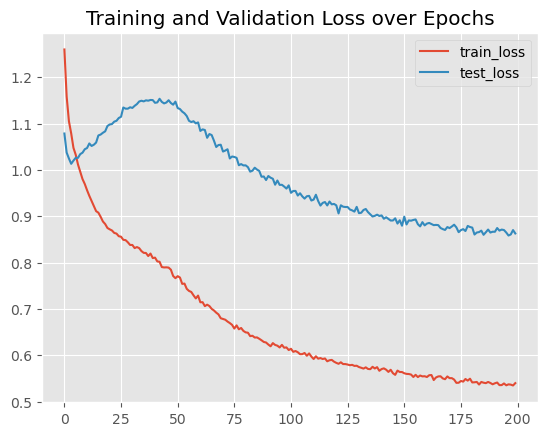

In [44]:
model_torch.fit(z.train, test=z.test, epochs=200)

In [45]:
comp = benchmark_comparison.Comparator(models=[lasso, lr, model_lstm, model_torch], model_names=['lasso', 'lr', 'lstm', 'transformer'])

In [46]:
comp.correl(z, mode='train')

,true,optimal,shift,lasso,lr,lstm
optimal,0.3481,nan,nan,nan,nan,nan
shift,0.3481,1.0000,nan,nan,nan,nan
lasso,0.0036,0.0024,0.0024,nan,nan,nan
lr,0.0073,0.0018,0.0018,0.6268,nan,nan
lstm,0.9963,0.3474,0.3474,0.0031,0.0075,nan
transformer,0.7461,0.3070,0.3070,0.0064,0.0097,0.7485


In [47]:
comp.correl(z, mode='test')

,true,optimal,shift,lasso,lr,lstm
optimal,0.3388,nan,nan,nan,nan,nan
shift,0.3388,1.0000,nan,nan,nan,nan
lasso,-0.0010,0.0023,0.0023,nan,nan,nan
lr,-0.0017,0.0023,0.0023,0.6614,nan,nan
lstm,0.0318,0.0358,0.0358,-0.0093,0.0073,nan
transformer,0.4629,0.2483,0.2483,0.0098,0.0146,0.1930


### Example of self-attention re-writing

In [62]:
from torch.nn.attention.flex_attention import BlockMask, _mask_mod_signature, and_masks, or_masks


class TransformerEncoderModel(nn.Module):
    def __init__(self, n_ts, n_f, n_rolling, mask, d_model=128, nhead=8, num_layers=2, dropout=0.8):
        super().__init__()
        self.mask = mask
        self.input_dim = n_ts * n_f
        self.d_model = d_model

        # Linear projection of (n_ts*n_f) features
        self.input_proj = nn.Linear(self.input_dim, d_model)

        # Positional encoding (learned or sinusoidal)
        self.pos_embedding = nn.Parameter(torch.randn(1, n_rolling, d_model))

        # Transformer encoder
        encoder_layer = TransformerEncoderLayer(
            d_model=d_model,
            nhead=nhead,
            dim_feedforward = 4 * d_model,
            dropout=dropout
        )
        self.encoder = TransformerEncoder(encoder_layer, num_layers=num_layers)

        # prediction
        self.decoder = nn.Sequential(
            nn.LayerNorm(d_model),
            nn.Linear(d_model, n_ts)
        )

    def forward(self, x, mask=None):
        # x: (batch, n_rolling, n_ts, n_f)
        B, n_rolling, n_ts, n_f = x.shape

        # Flatten dimensions that are not lookback
        x = x.reshape(B, n_rolling, n_ts*n_f)
        x = self.input_proj(x) + self.pos_embedding[:, :n_rolling, :]

        encoded = self.encoder(x, mask=self.mask)  

        # last time step’s embedding for prediction
        out = self.decoder(encoded[:, -1, :])  # (B, N)
        return out

##### Rolling mask

In [69]:
def causal_mask(b, h, q_idx, kv_idx):
    return q_idx >= kv_idx

def generate_sliding_window(window_size: int) -> _mask_mod_signature:
    def sliding_window(b, h, q_idx, kv_idx):
        return q_idx - kv_idx <= window_size

    sliding_window_mask = and_masks(sliding_window, causal_mask)
    sliding_window_mask.__name__ = f"sliding_window_{window_size}"
    return sliding_window_mask

In [63]:
mask = generate_sliding_window(3)
m = TransformerEncoderModel(Config.n_ts, Config.n_f, 10, mask=mask).to(device)
optimizer = torch.optim.Adam(m.parameters(), lr=0.001)


model_torch = torch_benchmarks.TorchWrapper(m, optimizer=optimizer)

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 200/200 [00:40<00:00,  4.93it/s]


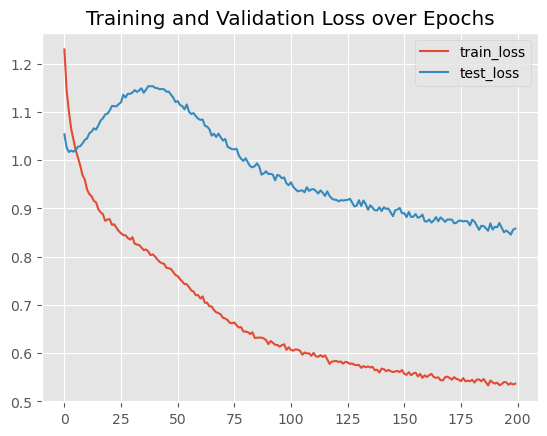

In [64]:
model_torch.fit(z.train, test=z.test, epochs=200)

In [65]:
comp = benchmark_comparison.Comparator(models=[lasso, lr, model_lstm, model_torch], model_names=['lasso', 'lr', 'lstm', 'transformer'])

In [66]:
comp.correl(z, mode='train')

,true,optimal,shift,lasso,lr,lstm
optimal,0.3481,nan,nan,nan,nan,nan
shift,0.3481,1.0000,nan,nan,nan,nan
lasso,0.0036,0.0024,0.0024,nan,nan,nan
lr,0.0073,0.0018,0.0018,0.6268,nan,nan
lstm,0.9963,0.3474,0.3474,0.0031,0.0075,nan
transformer,0.7499,0.3079,0.3079,0.0058,0.0098,0.7523


In [67]:
comp.correl(z, mode='test')

,true,optimal,shift,lasso,lr,lstm
optimal,0.3388,nan,nan,nan,nan,nan
shift,0.3388,1.0000,nan,nan,nan,nan
lasso,-0.0010,0.0023,0.0023,nan,nan,nan
lr,-0.0017,0.0023,0.0023,0.6614,nan,nan
lstm,0.0318,0.0358,0.0358,-0.0093,0.0073,nan
transformer,0.4583,0.2422,0.2422,0.0051,0.0075,0.1909


##### Dilation mask

In [80]:
def generate_dilated(dilation: int) -> _mask_mod_signature:
    def dilated_sliding_window(b, h, q_idx, kv_idx):
        diff = torch.abs(q_idx - kv_idx)
        is_dilated = (diff % dilation) == 0
        return is_dilated
    
    dilated_sliding_window_mask = and_masks(causal_mask, dilated_sliding_window)
    dilated_sliding_window_mask.__name__ = f"dilation_{dilation}"
    return dilated_sliding_window_mask

In [81]:
mask = generate_dilated(dilation=3)
m = TransformerEncoderModel(Config.n_ts, Config.n_f, 10, mask=mask).to(device)
optimizer = torch.optim.Adam(m.parameters(), lr=0.001)


model_torch = torch_benchmarks.TorchWrapper(m, optimizer=optimizer)

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 200/200 [00:37<00:00,  5.28it/s]


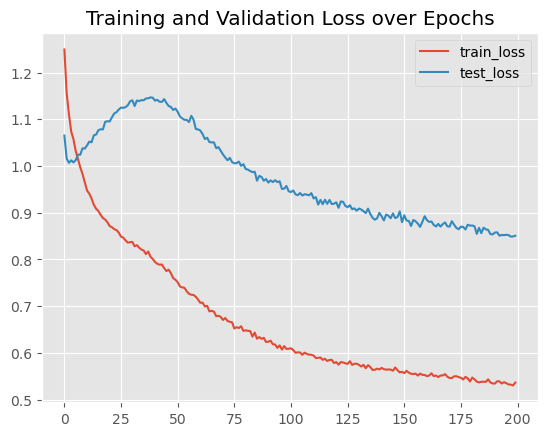

In [82]:
model_torch.fit(z.train, test=z.test, epochs=200)

In [83]:
comp = benchmark_comparison.Comparator(models=[lasso, lr, model_lstm, model_torch], model_names=['lasso', 'lr', 'lstm', 'transformer'])

In [84]:
comp.correl(z, mode='train')

,true,optimal,shift,lasso,lr,lstm
optimal,0.3481,nan,nan,nan,nan,nan
shift,0.3481,1.0000,nan,nan,nan,nan
lasso,0.0036,0.0024,0.0024,nan,nan,nan
lr,0.0073,0.0018,0.0018,0.6268,nan,nan
lstm,0.9963,0.3474,0.3474,0.0031,0.0075,nan
transformer,0.7475,0.3079,0.3079,0.0073,0.0097,0.7498


In [85]:
comp.correl(z, mode='test')

,true,optimal,shift,lasso,lr,lstm
optimal,0.3388,nan,nan,nan,nan,nan
shift,0.3388,1.0000,nan,nan,nan,nan
lasso,-0.0010,0.0023,0.0023,nan,nan,nan
lr,-0.0017,0.0023,0.0023,0.6614,nan,nan
lstm,0.0318,0.0358,0.0358,-0.0093,0.0073,nan
transformer,0.4676,0.2490,0.2490,0.0092,0.0112,0.1857


##### Dilation mask combined with rolling

In [87]:
def dilation_rolling(dilation: int, window: int) -> _mask_mod_signature:
    return or_masks(generate_dilated(dilation), generate_sliding_window(window))

In [88]:
mask = dilation_rolling(dilation=3, window=2)
m = TransformerEncoderModel(Config.n_ts, Config.n_f, 10, mask=mask).to(device)
optimizer = torch.optim.Adam(m.parameters(), lr=0.001)


model_torch = torch_benchmarks.TorchWrapper(m, optimizer=optimizer)

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 200/200 [00:37<00:00,  5.38it/s]


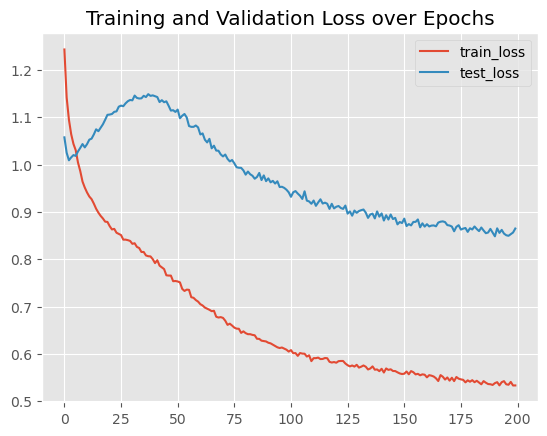

In [89]:
model_torch.fit(z.train, test=z.test, epochs=200)

In [90]:
comp = benchmark_comparison.Comparator(models=[lasso, lr, model_lstm, model_torch], model_names=['lasso', 'lr', 'lstm', 'transformer'])

In [91]:
comp.correl(z, mode='train')

,true,optimal,shift,lasso,lr,lstm
optimal,0.3481,nan,nan,nan,nan,nan
shift,0.3481,1.0000,nan,nan,nan,nan
lasso,0.0036,0.0024,0.0024,nan,nan,nan
lr,0.0073,0.0018,0.0018,0.6268,nan,nan
lstm,0.9963,0.3474,0.3474,0.0031,0.0075,nan
transformer,0.7472,0.3075,0.3075,0.0070,0.0104,0.7497


In [92]:
comp.correl(z, mode='test')

,true,optimal,shift,lasso,lr,lstm
optimal,0.3388,nan,nan,nan,nan,nan
shift,0.3388,1.0000,nan,nan,nan,nan
lasso,-0.0010,0.0023,0.0023,nan,nan,nan
lr,-0.0017,0.0023,0.0023,0.6614,nan,nan
lstm,0.0318,0.0358,0.0358,-0.0093,0.0073,nan
transformer,0.4617,0.2436,0.2436,0.0057,0.0098,0.1906


## DRAFT - Modifying the attention matrix sparsity

#### Attention Gym examples

In [205]:
import torch
from attn_gym.utils import cdiv
from torch.nn.attention.flex_attention import BlockMask, _mask_mod_signature, and_masks, or_masks



def causal_mask(b, h, q_idx, kv_idx):
    return q_idx >= kv_idx


def create_causal_block_mask_fast(
    batch_size: int | None,
    num_heads: int | None,
    q_seq_len: int,
    kv_seq_len: int,
    device: torch.device,
    block_size: int = 128,
    separate_full_blocks: bool = True,
) -> BlockMask:
    """Create a causal block mask efficiently without materializing the full mask.

    This function generates the block mask data structure directly for causal attention,
    avoiding the need to create and process a full dense mask. This is much more efficient
    for long sequences.

    Args:
        q_seq_len: Query sequence length
        kv_seq_len: Key/value sequence length
        device: Device to create tensors on
        batch_size: Batch size (defaults to 1 if None)
        num_heads: Number of attention heads (defaults to 1 if None)
        block_size: Block size for the block mask (both Q and KV use same size)
        separate_full_blocks: Whether to separate full blocks from partial blocks

    Returns:
        BlockMask: Block mask object for causal attention
    """
    if batch_size is None:
        batch_size = 1
    if num_heads is None:
        num_heads = 1
    if isinstance(block_size, tuple):
        q_block_size, kv_block_size = block_size
    else:
        q_block_size = kv_block_size = block_size

    num_q_blocks = cdiv(q_seq_len, q_block_size)
    num_kv_blocks = cdiv(kv_seq_len, kv_block_size)

    # For causal mask, each query block can attend to all KV blocks up to and including
    # the diagonal block
    kv_num_blocks = torch.zeros(
        (batch_size, num_heads, num_q_blocks), dtype=torch.int32, device=device
    )
    kv_indices = torch.zeros(
        (batch_size, num_heads, num_q_blocks, num_kv_blocks), dtype=torch.int32, device=device
    )

    if separate_full_blocks:
        full_kv_num_blocks = torch.zeros(
            (batch_size, num_heads, num_q_blocks), dtype=torch.int32, device=device
        )
        full_kv_indices = torch.zeros(
            (batch_size, num_heads, num_q_blocks, num_kv_blocks), dtype=torch.int32, device=device
        )
    else:
        full_kv_num_blocks = None
        full_kv_indices = None

    for q_block_idx in range(num_q_blocks):
        # For causal attention, query block i can attend to KV blocks [0, i]
        # The last block in the diagonal may be partial
        num_full_blocks = min(q_block_idx, num_kv_blocks)
        num_partial_blocks = 1 if q_block_idx < num_kv_blocks else 0

        if separate_full_blocks:
            assert full_kv_num_blocks is not None
            assert full_kv_indices is not None

            if num_partial_blocks > 0:
                min_q_index = q_block_idx * q_block_size
                max_kv_index = min((q_block_idx + 1) * kv_block_size - 1, kv_seq_len - 1)
                is_diagonal_full = min_q_index >= max_kv_index
            else:
                is_diagonal_full = False

            if is_diagonal_full:
                # Diagonal block is full - move it from partial to full
                full_kv_num_blocks[:, :, q_block_idx] = num_full_blocks + 1
                kv_num_blocks[:, :, q_block_idx] = 0  # No partial blocks

                # Set indices for all full blocks (including diagonal)
                indices = torch.arange(num_full_blocks + 1, device=device)
                full_kv_indices[:, :, q_block_idx, : num_full_blocks + 1] = indices
            else:
                # Diagonal block is partial (or doesn't exist)
                full_kv_num_blocks[:, :, q_block_idx] = num_full_blocks
                kv_num_blocks[:, :, q_block_idx] = num_partial_blocks

                # Set indices for full blocks
                if num_full_blocks > 0:
                    indices = torch.arange(num_full_blocks, device=device)
                    full_kv_indices[:, :, q_block_idx, :num_full_blocks] = indices

                # Set index for partial block
                if num_partial_blocks > 0:
                    kv_indices[:, :, q_block_idx, 0] = q_block_idx
        else:
            # All blocks go into partial
            total_blocks = num_full_blocks + num_partial_blocks
            kv_num_blocks[:, :, q_block_idx] = total_blocks
            if total_blocks > 0:
                indices = torch.arange(total_blocks, device=device)
                kv_indices[:, :, q_block_idx, :total_blocks] = indices

    return BlockMask.from_kv_blocks(
        kv_num_blocks=kv_num_blocks,
        kv_indices=kv_indices,
        full_kv_num_blocks=full_kv_num_blocks,
        full_kv_indices=full_kv_indices,
        BLOCK_SIZE=(q_block_size, kv_block_size),
        mask_mod=causal_mask,
        seq_lengths=(q_seq_len, kv_seq_len),
    )

def generate_sliding_window(window_size: int) -> _mask_mod_signature:
    """Generates a sliding window attention mask with a given window size.
    Args:
        window_size: The size of the sliding window.

    Note:
        We assume that the window size represents the lookback size and we mask out all future tokens
        similar to causal masking.
    """

    def sliding_window(b, h, q_idx, kv_idx):
        return q_idx - kv_idx <= window_size

    sliding_window_mask = and_masks(sliding_window, causal_mask)
    sliding_window_mask.__name__ = f"sliding_window_{window_size}"
    return sliding_window_mask


def generate_dilated_sliding_window(window_size: int, dilation: int) -> _mask_mod_signature:
    """Generates a dilated sliding window attention mask.
    Args:
        window_size: The size of the sliding window.
        dilation: The dilation factor for the sliding window.

    Note:
        Query at position i can only attend to keys within a window of size `window_size`
        centered around i, where the keys are at positions j such that:
        * abs(i - j) <= window_size
        * abs(i - j) % dilation == 0
    """

    def dilated_sliding_window(b, h, q_idx, kv_idx):
        diff = torch.abs(q_idx - kv_idx)
        in_window = diff <= window_size
        is_dilated = (diff % dilation) == 0
        return in_window & is_dilated
    
    dilated_sliding_window_mask = and_masks(causal_mask, dilated_sliding_window)
    dilated_sliding_window_mask.__name__ = f"dilated_sliding_window_{window_size}_dilation_{dilation}"
    return dilated_sliding_window_mask


"""Visualize the attention scores of causal masking.

Args:
    device (str): Device to use for computation. Defaults
"""
import torch
from attn_gym import visualize_attention_scores

B, H, SEQ_LEN, HEAD_DIM = 1, 1, 12, 1

def make_tensor():
    return torch.ones(B, H, SEQ_LEN, HEAD_DIM, device=device)

query, key = make_tensor(), make_tensor()

visualize_attention_scores(query, key, mask_mod=causal_mask, device=device, name="causal_mask")
mask = generate_sliding_window(3)
visualize_attention_scores(query, key, mask_mod=mask, device=device, name="sliding_mask")
mask = generate_dilated_sliding_window(6, 3)
visualize_attention_scores(query, key, mask_mod=mask, device=device, name="dilated_mask")

Visualization saved as causal_mask.png
Visualization saved as sliding_mask.png
Visualization saved as dilated_mask.png
